# This notebook may be used to generate data for Fig. 1 and also to make the plot

In [1]:
import numpy as np
from math import exp,sqrt,log, pi, sin, cos
import math
import numpy.random as rand
import timeit

%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import sys
import os
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
   sys.path.append(nb_dir)
import timeit

from scipy.stats import chi2
from scipy.fftpack import fft, fft2
from scipy.signal import argrelextrema

from scipy import signal

In [2]:
def Vin(t):   # square wave
    Vin = np.zeros(2)
    if freq_cond == 0:
        y1 = mag1*signal.square(2 * np.pi * freq1 * t, duty = 0.5)
    else:
        y1 = mag1*signal.square(2 * np.pi * freq1 * t, duty = 0.5*freq1/freq2)
    y2 = mag2*signal.square(2 * np.pi * freq2 * t, duty = 0.5)
    if y1 < 0.2:
        y1 = 0.2
    if y2 < 0.2:
        y2 = 0.2
    Vin[0] = y1
    Vin[1] = y2
    return Vin

def sampled_stimulus(val1, val2):
    sampledStim = np.zeros(2)
    v1 = val1 + rand.normal(0, standard_dev_phys_stim)
    v2 = val2 + rand.normal(0, standard_dev_phys_stim)
    if v1 < 0.1:
        v1 = 0.1
    if v2 < 0.1:
        v2 = 0.1
    sampledStim[0] = pow(v1, gamma)
    sampledStim[1] = pow(v2, gamma)
    return sampledStim

def Fdet_mDDM(y, Vin):    # as this notebook produces C-IM data, DDM is not time dependent here
    Fdet = np.zeros(1)
    In1 = Vin[0]
    In2 = Vin[1]
    Fdet[0] = q*(In1-In2) + drift_var_trial
    return Fdet  # 1D array

def Frand_mDDM(stdDev):
    Frand = np.zeros(1)
    xRand0 = rand.normal(0,1)
    Frand[0] = stdDev*xRand0
    return Frand  # 1D array

def Fdet_Cross(y, Vin):
    #linear cross-inhibition model time dependent:
    Fdet = np.zeros(2)
    Fdet[0] = -k*y[0]  - beta*y[1] + q*Vin[0]  # to become feedforward
    Fdet[1] = -k*y[1]  - beta*y[0] + q*Vin[1]  # beta is w in some literature
    return Fdet

def Frand_Cross(stdDev):
    Frand = np.zeros(2)
    xRand0 = rand.normal(0,1)
    xRand1 = rand.normal(0,1)
    Frand[0] = stdDev*xRand0
    Frand[1] = stdDev*xRand1
    return Frand

In [3]:
def EulerRand(dt, y, Fdet, Frand, Vin, stdDev):
    fd = Fdet(y, Vin)
    fr = Frand(stdDev)
    yNew = y + dt*fd + fr*math.sqrt(dt)
    return yNew

In [9]:
standard_dev_phys_stim = 0.05
gamma = 0.5
# model parameters for linear cross inhibition
k = 0.5 # leak, originally = 0.8
q = 1 # conversion factor,  originally = 1
beta = 0.25# inhibition strength, originally =2

delps = 0  #  phase shift between inputs
freq1 = 6  # frequencies of signal 1 and 2
freq2 = 4
mag1 = 3   # magnitudes of the signals
mag2 = 2
#signal = np.cos(omega*time) + np.sin(2*omega*time)
noiseCoef = 0.1
sigma = 0.1   # originally = 0.25

In [242]:
freq_cond = 0 # 0 or 1
if freq_cond == 0:
    rand.seed(47533435) #for freq_cond=0
else:
    rand.seed(53533435) #for freq_cond=1

tmax = 15   
yinit = np.array([0.0, 0.0])  #initial conditions,  y is 2D array
xinit = np.array([0.0])      # x relates to mDDM data
ht = 0.001  #time step
drift_var_trial = rand.normal(0,0.1)

InputSignal = []
InputTransformed = []
time = []  
Ysol = []
Xsol = []

t = 0
y = yinit + rand.uniform(0,0.2,2)
x = xinit + rand.uniform(-0.1,0.1)
Input = Vin(t)
InTransform = sampled_stimulus(Input[0], Input[1])

InputSignal.append(Input)
InputTransformed.append(InTransform)
time.append(t)
Ysol.append(y)
Xsol.append(x)

while t < tmax:    # can implement threshold as well as or instead of time limit
    stdDev = sigma+0.2
    #print(stdDev)
    y = EulerRand(ht, y, Fdet_Cross, Frand_Cross, InTransform, stdDev) 
    for jj in range(len(y)):
        y[jj] = max(0, y[jj])
    variance_tot = (sigma*sigma) + noiseCoef*(InTransform[0]**2 + InTransform[1]**2)
    stdDev = math.sqrt(variance_tot) 
    #print(stdDev)
    x = EulerRand(ht, x, Fdet_mDDM, Frand_mDDM, InTransform, stdDev)
    t = t + ht
    Input = Vin(t)
    InTransform = sampled_stimulus(Input[0], Input[1])
    
    InputSignal.append(Input)
    InputTransformed.append(InTransform)
    time.append(t)
    Ysol.append(y)
    Xsol.append(x)

<IPython.core.display.Javascript object>


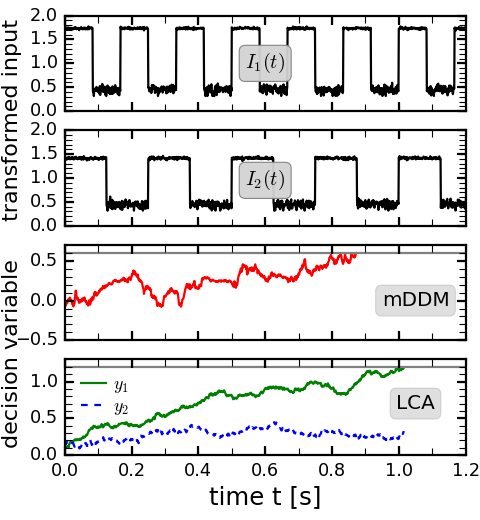

In [245]:
#figAll = plt.figure(figsize=(6,14))
fig3, ax = plt.subplots(4, sharex=True, sharey=False, figsize=(6,6.5))
plt.subplots_adjust(left=0.135, bottom=0.125, right=0.97, top=0.97,
                wspace=None, hspace=0.2)
ax[0].plot(time, [InputTransformed[kk][sigxy] for kk in range(len(InputTransformed))], 'k', lw=2)
ax[0].set_ylim([0, 2])
ax[1].plot(time, [InputTransformed[kk][sigxy+1] for kk in range(len(InputTransformed))], 'k', lw=2)
ax[1].set_ylim([0, 2])
ax[2].plot(time[0:index_X], Xsol[0:index_X], c='r', lw=2)
ax[2].plot([0,1.2],[0.6,0.6], lw=2, c='grey')
if freq_cond == 0:
    ax[2].set_ylim([-0.5, 0.7])
else:
    ax[2].set_ylim([-0.5, 0.7])
ax[3].plot(time[0:index_Y1], Y1[0:index_Y1], c='g', lw=2, label=r'$y_1$')
ax[3].plot(time[0:index_Y1], Y2[0:index_Y1], c='b', ls='--', lw=2, label=r'$y_2$')
ax[3].plot([0,1.2],[1.2,1.2], lw=2, c='grey')
ax[3].set_ylim([0, 1.3])
ax[3].legend(ncol=1, bbox_to_anchor=(0.2, 1.0), fontsize=16, 
             handlelength=2, handletextpad=0.1, labelspacing=0.1, 
             fancybox=False, frameon=False)
bbox_props1 = dict(boxstyle="round", fc="lightgrey", ec="0.5", alpha=0.95)
bbox_props = dict(boxstyle="round", fc="grey", ec="0.5", alpha=0.25)
if freq_cond == 0:
    ax[0].text(0.6, 1, r"$I_1(t)$", ha="center", va="center", size=18,
            bbox=bbox_props1)
    ax[1].text(0.6, 0.95, r"$I_2(t)$", ha="center", va="center", size=18,
            bbox=bbox_props1)
    ax[2].text(1.05, 0., r"mDDM", ha="center", va="center", size=18,
            bbox=bbox_props)
    ax[3].text(1.05, 0.7, r"LCA", ha="center", va="center", size=18,
            bbox=bbox_props)
else:
    ax[0].text(0.56, 1, r"$I_1(t)$", ha="center", va="center", size=18,
            bbox=bbox_props1)
    ax[1].text(0.56, 0.95, r"$I_2(t)$", ha="center", va="center", size=18,
            bbox=bbox_props1)
    ax[2].text(0.88, 0, r"mDDM", ha="center", va="center", size=18,
            bbox=bbox_props)
    ax[3].text(0.9, 0.3, r"LCA", ha="center", va="center", size=18,
            bbox=bbox_props)

if freq_cond == 0:
    plt.xlim(0,1.2)
else:
    plt.xlim(0,1.2)
    
#plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False);
plt.xlabel(r'time t [s]', fontsize=22)
#fig3.text(0.5, 0.04, r'time $t$', ha='center', fontsize=26)
fig3.text(0.005, 0.32, r'decision variable', va='center', rotation='vertical', fontsize=20)
fig3.text(0.005, 0.77, r'transformed input', va='center', rotation='vertical', fontsize=20);

for axj in ax:
    axj.tick_params(labelbottom='on',labeltop='off', labelleft='on', labelright='off', pad=6)
    plt.setp( axj.xaxis.get_majorticklabels(), rotation=0, fontsize=16)
    plt.setp( axj.yaxis.get_majorticklabels(), rotation=0, fontsize=16)

    axj.xaxis.set_major_locator(ticker.MultipleLocator(0.2))
    axj.xaxis.set_minor_locator(ticker.MultipleLocator(0.1))
    axj.yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    axj.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))

    for axis in ['top','bottom','left','right']:
        axj.spines[axis].set_linewidth(2)
    axj.tick_params('both', length=8, width=2, which='major')
    axj.tick_params('both', length=6, width=1, which='minor')

#bbox_props = dict(boxstyle="round", fc="grey", ec="0.5", alpha=0.25)
#ax.text(0.7, 0.975, r"$d_m(t=0)=7.5$, $\Delta d(t=0)=0$", ha="center", va="center", size=20,
#        bbox=bbox_props)
#ax.annotate(r'$d_m=7.5$',
#            xy=(0.7, 0.97), xycoords='data', fontsize=28,
#            horizontalalignment='center', verticalalignment='center')

#plt.legend(loc='lower left', fontsize=20, handlelength=3, fancybox=True)
#fig3.set_tight_layout(True) 
#fig3.subplots_adjust(hspace=0.2)
#plt.tight_layout()

In [246]:
#fig3.savefig('Fig_methods_freqCond_'+str(freq_cond)+'.png', format='png', dpi=150)